In [14]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import wrangle
import prepare as prep

from env import github_token, github_username

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import re
import unicodedata
import nltk

## Acquire and Prep

In [15]:
df = pd.read_json("data.json")
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             166 non-null    object
 1   language         157 non-null    object
 2   readme_contents  166 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB


In [17]:
df_copy = df.copy()

In [18]:
df = prep.prep_data(df)
df.head()

,repo,language,original,clean,more_clean
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid 19 prov...,reduction life expectancy brazil covid 19 prov...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual changes life expectancy illust...,animated annual change life expectancy illustr...
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,thoracic surgery lung cancer data set uci mach...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,hackerrank data scientist hiring test predict ...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p align center img src https github com oxford...,p align center img src http github com oxfordd...


In [19]:
df.language.value_counts()

other     65
Python    48
R         31
HTML      22
Name: language, dtype: int64

In [20]:
df_all_languages = prep.prep_data(df_copy, keep_top_languages=False)

In [21]:
df_all_languages.language.value_counts()

Python         67
R              31
HTML           22
JavaScript     16
Stata           5
Java            3
Dart            3
Scala           2
Swift           2
MATLAB          1
Shell           1
TypeScript      1
Ruby            1
Objective-C     1
Scheme          1
Name: language, dtype: int64

## Split Data

In [22]:
def split_data(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return train, validate, test

In [23]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((92, 5), (40, 5), (34, 5))

In [24]:
train_languages, validate_languages, test_languages = split_data(df_all_languages)
train_languages.shape

(92, 5)

## Explore 
#### Pre-Processing

In [25]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")

,n,percent
other,35,0.380435
Python,28,0.304348
HTML,15,0.163043
R,14,0.152174


In [26]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [27]:
## Create lists of words for each language category
other = clean(' '.join(train[train.language == 'other'].original))
python = clean(' '.join(train[train.language == 'Python'].original))
r = clean(' '.join(train[train.language == 'R'].original))
html = clean(' '.join(train[train.language == 'HTML'].original))
all_words = clean(' '.join(train.original))

In [28]:
## Transform lists into series
other_freq = pd.Series(other).value_counts()
python_freq = pd.Series(python).value_counts()
r_freq = pd.Series(r).value_counts()
html_freq = pd.Series(html).value_counts()
all_freq = pd.Series(all_words).value_counts()

other_freq.head()

feature       100
life           71
expectancy     65
data           59
file           52
dtype: int64

In [29]:
#Create a word_counts data frame we can work with

word_counts = (pd.concat([all_freq, other_freq, python_freq, r_freq, html_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'python', 'r', 'html'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,other,python,r,html
0,15,1,13,1,0
000,1,0,1,0,0
00074,1,0,1,0,0
00078,1,0,1,0,0
00123,1,0,1,0,0


### Answer questions about word frequency:

**What are the most frequently occuring words?**

In [30]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,other,python,r,html
life,220,71,87,33,29
expectancy,203,65,80,31,27
data,174,59,72,27,16
feature,123,100,23,0,0
country,109,29,58,12,10
file,89,52,6,6,25
1,63,36,18,6,3
health,62,9,31,19,3
model,61,18,35,6,2
year,58,11,23,16,8


**Are there any words that uniquely identify one of the coding languages?**

In [31]:
pd.concat([word_counts[word_counts.other == 0].sort_values(by='other').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.r == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.html == 0].sort_values(by='html').tail(6)])

,all,other,python,r,html
e0,4,0,0,4,0
dyspnoea,1,0,1,0,0
dynamic_gdp_graph,1,0,0,0,1
dying,2,0,1,1,0
eastward,1,0,1,0,0
zubrod,1,0,1,0,0
excluded,1,1,0,0,0
excess,1,0,0,1,0
excel,2,1,0,1,0
examining,1,0,0,0,1


Text(0.5, 1.0, 'Proportion of Language Word Frequency for the 20 most common words')

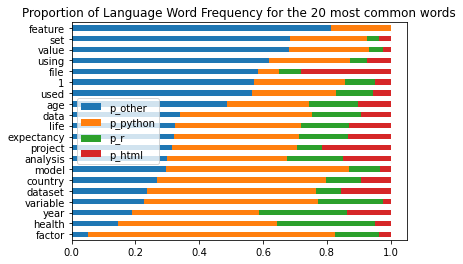

In [33]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_other=word_counts.other / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_r=word_counts.r / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_other', 'p_python', 'p_r', 'p_html']]
 .tail(20)
 .sort_values('p_other')
 .plot.barh(stacked=True))

plt.title('Proportion of Language Word Frequency for the 20 most common words')


### Create and Visualize Bigrams

In [34]:
# Top 20 other
top_20_other_bigrams = (pd.Series(nltk.ngrams(other, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(life, expectancy)    64
(sex, age)            15
(expectancy, sex)     14
(age, income)         12
(survival, rate)      12
dtype: int64

In [35]:
# Top 20 python 
top_20_python_bigrams = (pd.Series(nltk.ngrams(python, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(life, expectancy)     79
(machine, learning)    13
(1, f)                 11
(f, 0)                 11
(aligncenter, img)      9
dtype: int64

In [36]:
# Top 20 r
top_20_r_bigrams = (pd.Series(nltk.ngrams(r, 2))
                      .value_counts()
                      .head(20))

top_20_r_bigrams.head()

(life, expectancy)           30
(per, 1000)                   5
(change, life)                5
(global, health)              5
(1000, populationobjectn)     5
dtype: int64

In [37]:
# Top 20 html
top_20_html_bigrams = (pd.Series(nltk.ngrams(html, 2))
                      .value_counts()
                      .head(20))

top_20_html_bigrams.head()

(life, expectancy)    27
(rmd, file)           14
(mean, median)        10
(median, survival)     8
(html, file)           7
dtype: int64

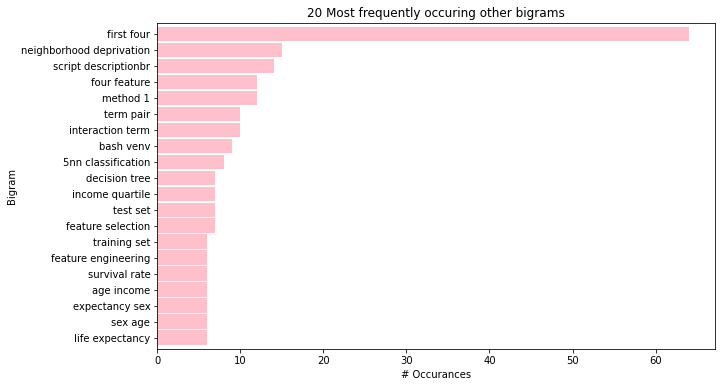

In [38]:
## Plot Top 20 Other

top_20_other_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring other bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


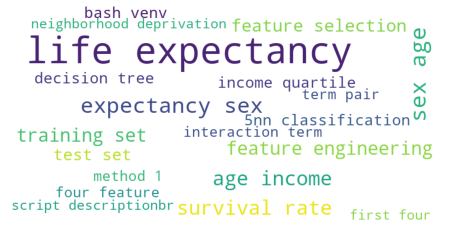

In [39]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

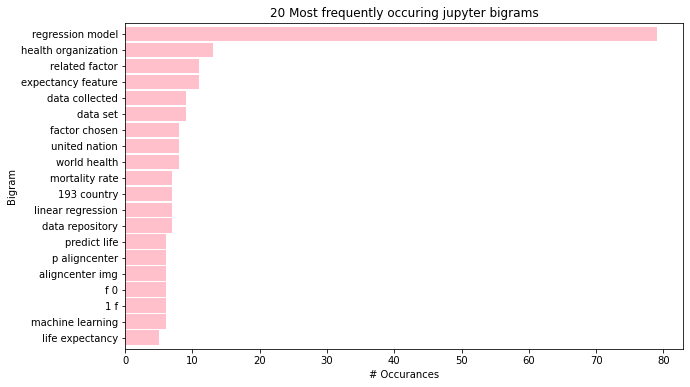

In [40]:
## Plot Top 20 python

top_20_python_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring jupyter bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


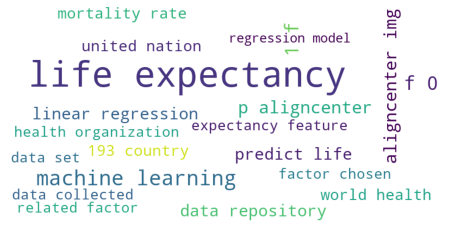

In [41]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

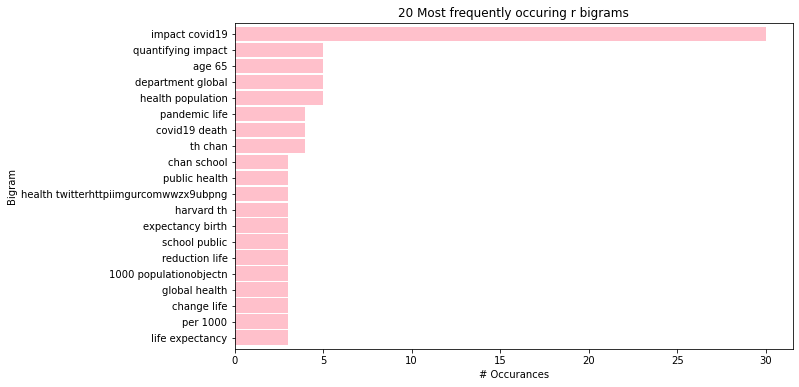

In [42]:
## Plot Top 20 r

top_20_r_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring r bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_r_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

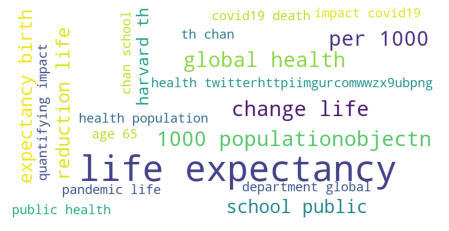

In [43]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_r_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

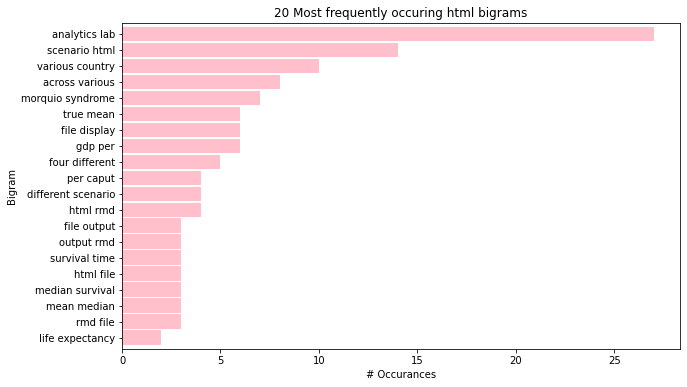

In [44]:
## Plot Top 20 html

top_20_html_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring html bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

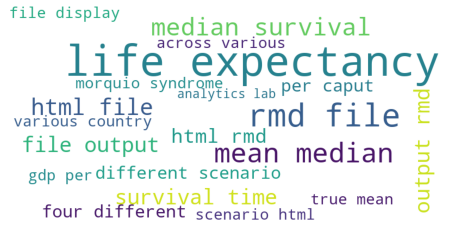

In [45]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_html_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Add Other Features to Explore